# Mục đích
> Trong bài này, chúng ta sẽ đi qua cách sử dụng tensorflow dataset để xử lý dữ liệu thực tế.
> 1. Chuyển dữ liệu thành dạng tensorflow dataset
> 2. Biến đổi dữ liệu:
    - Resize/Crop
    - Flip/rotate
    - Brightness/contrast
> 3. Các technique khác trong quá trình train dữ liệu

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
path = '/home/ddpham/git/TFExam/data/'

In [ ]:
!ls {path}/'sw'

test  train


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Tạo tập dữ liệu

## Sử dụng `image_dataset_from_directory`

Trong `keras.preprocesing` từ version tensorflow 2.3, chúng ta có phương pháp `image_dataset_from_directory` có thể sử dụng để tạo tập dữ liệu:

In [ ]:
?keras.preprocessing.image_dataset_from_directory

Signature:
keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
)
Docstring:
Generates a `tf.data.Dataset` from image files in a directory.

If your directory structure is:

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

Then calling `image_dataset_from_directory(main_directory, labels='inferred')`
will return a `tf.data.Dataset` that yields batches of images from
the subdirectories `class_a` and `class_b`, together with labels
0 and 1 (0 corresponding to `class_a` and 1 corresponding to `class_b`).

Supported image formats: jpeg, png, bmp, gif.
Animated gifs are truncated to the first frame.

Arguments:
  directory: Directory where

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory=f'{path}/sw/train'
    , labels='inferred'
    , label_mode='categorical'
    , batch_size=32
    , image_size=(224, 224)
)
valid_ds = keras.preprocessing.image_dataset_from_directory(
    directory = f'{path}/sw/test'
    , labels='inferred'
    , label_mode='categorical'
    , batch_size=32
    , image_size=(224, 224)
)

Found 99 files belonging to 2 classes.
Found 43 files belonging to 2 classes.


In [ ]:
?train_ds

Type:           BatchDataset
String form:    <BatchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>
Length:         4
File:           ~/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py
Docstring:      A `Dataset` that batches contiguous elements from its input.
Init docstring: See `Dataset.batch()` for details.


In [ ]:
train_ds.__class__, train_ds

(tensorflow.python.data.ops.dataset_ops.BatchDataset,
 <BatchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>)

__Lưu ý:__

Phương pháp `image_dataset_from_directory` là phương pháp tương đối đơn giản và đã hỗ trợ chúng ta trong việc resize lại ảnh, đặt batch_size. 
Còn nhiều phương pháp nữa mà chúng ta sẽ đề cập tới sau đây.

In [ ]:
dir(train_ds)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_variable_with_custom_getter',
 '_apply_options',
 '_as_serialized_graph',
 '_batch_size',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_drop_remainder',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_has_captured_ref',
 '_input_dataset',
 '_inputs',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_de

### Kiểm tra dữ liệu

In [ ]:
# Lấy tên thực tế của labels:
class_names = train_ds.class_names
class_names

['swallow', 'swift']

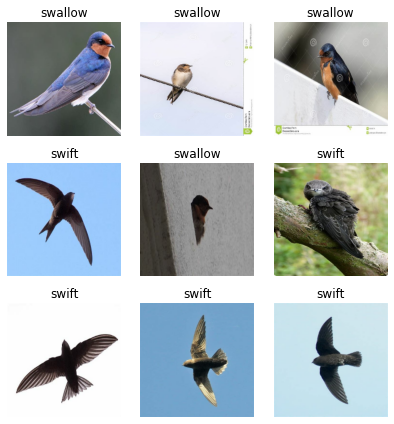

In [ ]:
# Kiểm tra dữ liệu của 1 batch:
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
    # Kiểm tra 9 ảnh:
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(np.uint8(images[i]))
        plt.title(class_names[np.int8(labels[i][1])])
        plt.axis('off')
        plt.tight_layout()

## Xây dựng model

> Chúng ta sẽ sử dụng một model đã được học trước, thay vì tạo 1 model từ đầu

### Sử dụng pretrained model - resnet
> resnet là một trong những pretrained model rất nổi tiếng đã chiến thắng trong cuộc thi Imagenet năm 2015. Ngoài ra, chúng ta có thể sử dụng các model khác như: EfficientNet, DenseNet, Inception, Xception...

In [ ]:
dir(keras.applications)

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'densenet',
 'efficientnet',
 'imagenet_utils',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3',
 'nasnet',
 'resnet',
 'resnet50',
 'resnet_v2',
 'vgg16',
 'vgg19',
 'xception']

In [ ]:
from keras.applications import resnet50

Chúng ta sử dụng model đã được học sẵn là ResNet50, tuy nhiên sẽ không dùng layer cuối vì tác vụ khác so với bài toán của chúng ta.

In [ ]:
# Tạo một base model, trong đó, lọc bỏ 2 layers cuối cùng (flatten và predict) của model đã được đào tạo rồi:
model = resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=[224, 224, 3])
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

__Lưu ý:__
Trước khi bổ sung thêm các layer chúng ta cần có để xử lý các bài toán của chúng ta, hay đóng băng các layer trước của pretrained model, để đảm bảo weights không bị phá vỡ trong quá trình train cho dữ liệu mới. Chỉ khi nào model train với dữ liệu mới cho kết quả thực sự tốt, chúng ta mới quyết định giã đông (thôi đóng  băng) các layer này và train lại model của chúng ta để đạt được kết quả cao hơn.

In [ ]:
for layer in model.layers:
    layer.trainable=False

Sau đó, bổ sung thêm layer cho ứng dụng của chúng ta. Ở đây, chúng ta sẽ tạo lại layer flatten và layer prediction cuối cùng để dự báo kết quả.

In [ ]:
flatten = keras.layers.Flatten()(model.output) # Kéo phẳng kết quả của model ResNet50
prediction = keras.layers.Dense(2, activation='sigmoid', name='prediction')(flatten)
base_model = keras.models.Model(inputs=model.inputs, outputs=prediction)
base_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Tổng kết model:
base_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

### Preprocess_input
> Trong các model đã được train sẵn của keras (applications), đều có phương pháp tiền sử lý dữ liệu đầu vào (`preprocess_input`), để biến đổi dữ liệu thành dạng dữ liệu đầu vào cho các model được train sẵn. Với resnet50, ảnh sẽ được biến đổi từ dạng RGB (red, green, blue) sang dạng (BGR) và vs từng channel màu này, các pixel ảnh được biến đổi về dạng zero-centered tương đồng với dữ liệu ImageNet (dữ liệu mà model ResNet50 sử dụng để đào tạo) mà không cần biến đổi scaling (chỉ đơn giản là chia các pixel cho mean pixel).

In [ ]:
?resnet50.preprocess_input

Signature: resnet50.preprocess_input(x, data_format=None)
Docstring:
Preprocesses a tensor or Numpy array encoding a batch of images.

Usage example with `applications.MobileNet`:

```python
i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = tf.keras.applications.mobilenet.preprocess_input(x)
core = tf.keras.applications.MobileNet()
x = core(x)
model = tf.keras.Model(inputs=[i], outputs=[x])

image = tf.image.decode_png(tf.io.read_file('file.png'))
result = model(image)
```

Arguments:
  x: A floating point `numpy.array` or a `tf.Tensor`, 3D or 4D with 3 color
    channels, with values in the range [0, 255].
    The preprocessed data are written over the input data
    if the data types are compatible. To avoid this
    behaviour, `numpy.copy(x)` can be used.
  data_format: Optional data format of the image tensor/array. Defaults to
    None, in which case the global setting
    `tf.keras.backend.image_data_format()` is used (unless you changed 

In [ ]:
# Tạo hàm biến đổi dữ liệu ảnh theo dạng dữ liệu đầu vào của resnet50:
# The images are converted from RGB to BGR, then each color channel is
# zero-centered with respect to the ImageNet dataset, without scaling.
def preprocess_ds(image, label):
    image = resnet50.preprocess_input(image)
    return (image, label)

In [ ]:
?train_ds.map

Signature: train_ds.map(map_func, num_parallel_calls=None, deterministic=None)
Docstring:
Maps `map_func` across the elements of this dataset.

This transformation applies `map_func` to each element of this dataset, and
returns a new dataset containing the transformed elements, in the same
order as they appeared in the input. `map_func` can be used to change both
the values and the structure of a dataset's elements. For example, adding 1
to each element, or projecting a subset of element components.

>>> dataset = Dataset.range(1, 6)  # ==> [ 1, 2, 3, 4, 5 ]
>>> dataset = dataset.map(lambda x: x + 1)
>>> list(dataset.as_numpy_iterator())
[2, 3, 4, 5, 6]

The input signature of `map_func` is determined by the structure of each
element in this dataset.

>>> dataset = Dataset.range(5)
>>> # `map_func` takes a single argument of type `tf.Tensor` with the same
>>> # shape and dtype.
>>> result = dataset.map(lambda x: x + 1)

>>> # Each element is a tuple containing two `tf.Tensor` objects.


In [ ]:
# hàm map trong dataset của keras có thể hỗ trợ chúng ta map các phương pháp biến đổi dữ liệu vào trong dữ liệu dạng dataset:
train_ds = train_ds.map(preprocess_ds)
valid_ds = valid_ds.map(preprocess_ds)

In [ ]:
base_model.fit(train_ds, epochs=10, validation_data=valid_ds)

Epoch 1/10
4/4 [==============================] - 5s 635ms/step - loss: 6.7671 - accuracy: 0.6672 - val_loss: 7.6561 - val_accuracy: 0.7907
Epoch 2/10
4/4 [==============================] - 1s 245ms/step - loss: 2.0939 - accuracy: 0.9288 - val_loss: 2.9445 - val_accuracy: 0.7907
Epoch 3/10
4/4 [==============================] - 1s 246ms/step - loss: 0.3791 - accuracy: 1.0000 - val_loss: 2.5688 - val_accuracy: 0.7907
Epoch 4/10
4/4 [==============================] - 1s 246ms/step - loss: 2.1737e-04 - accuracy: 1.0000 - val_loss: 2.5630 - val_accuracy: 0.7907
Epoch 5/10
4/4 [==============================] - 1s 243ms/step - loss: 4.0423e-05 - accuracy: 1.0000 - val_loss: 2.5616 - val_accuracy: 0.7907
Epoch 6/10
4/4 [==============================] - 1s 247ms/step - loss: 2.3326e-05 - accuracy: 1.0000 - val_loss: 2.5603 - val_accuracy: 0.7907
Epoch 7/10
4/4 [==============================] - 1s 250ms/step - loss: 1.5146e-05 - accuracy: 1.0000 - val_loss: 2.5592 - val_accuracy: 0.7907
Epoc

Chúng ta có thể thấy kết quả thật chưa cao và đang bị overfit tương đối rõ ràng, vì chúng ta vẫn chưa hề sử dụng bất kỳ phương pháp biến đổi dữ liệu nào cả. Chúng ta sẽ làm vậy để xem kết quả có tiến bộ thêm được gì hay không.

## Biến đổi dữ liệu
> Vừa rồi chúng ta mới chỉ quy chuẩn dữ liệu về size 224 cho tất cả các ảnh và biến đổi ảnh về dạng zero-based centering cho ảnh trước khỉ đẩy vào pretrained model. Đây là bước biến đổi dữ liệu cơ bản chúng ta đã làm. Tuy nhiên, ngằn đó chưa đủ để chúng ta có kết quả tốt. Chúng ta sẽ đi sâu hơn về biến đổi dữ liệu sử dụng `ImageDataGenerator`.

In [ ]:
?image.ImageDataGenerator

Init signature:
image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None,
)
Docstring:     
Generate batches of tensor image data with real-time data augmentation.

 The data will be looped over (in batches).

Arguments:
    featurewise_center: Boolean.
        Set input mean to 0 over the dataset, feature-wise.
    samplewise_center: Boolean. Set each sample mean to 0.
    featurewise_std_normalization: Boolean.
        Divide inputs by std of the dataset, fe

__Lưu ý:__
Chúng ta sử dụng `ImageDataGenerator` giống như 1 phương pháp load các ảnh theo batch và xử lý biến đổi dữ liệu real-time. Đây là một trong nhưng cách làm tương đồng với dataloader của fastai và pytorch.

In [ ]:
def preprocess_ds_adj(tensor: tuple):
    tensor[0] = resnet50.preprocess_input(tensor[0])
    return tensor

In [ ]:
# Tạo một ImageDataGenerator:
data_generator = image.ImageDataGenerator(
    featurewise_center=True
    , featurewise_std_normalization=True
    , fill_mode='reflection'
    , rescale=1./255
    , preprocessing_function=preprocess_ds_adj
)

__Lưu ý:__
Ở đây chúng ta chỉ sử dụng phương pháp feature_center & featurewise_std_normalization để biến đổi dữ liệu cơ bản. và sử dụng fill_mode là reflection cho những ảnh resize mà to hơn chút xíu so vs ảnh gốc.

In [ ]:
dir(data_generator)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'principal_components',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standa

In [ ]:
?data_generator.flow_from_directory

Signature:
data_generator.flow_from_directory(
    directory,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    subset=None,
    interpolation='nearest',
)
Docstring:
Takes the path to a directory & generates batches of augmented data.

Arguments:
    directory: string, path to the target directory. It should contain one
      subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images inside
      each of the subdirectories directory tree will be included in the
      generator. See [this script](
        https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
          for more details.
    target_size: Tuple of integers `(height, width)`, defaults to `(256,
      256)`. The dimensions to which all images found will be resized.
    color_mode: One of "grayscale", "rgb", "rgba". Defa

In [ ]:
# Tạo tập dữ liệu, sử dụng phương pháp: `flow_from_directory:`
bs = 16
train_ds = data_generator.flow_from_directory(
    directory=f'{path}/sw/train'
    , target_size=(224, 224)
    , class_mode='categorical'
    , batch_size=bs
)
valid_ds = data_generator.flow_from_directory(
    directory=f'{path}/sw/test'
    , target_size=(224, 224)
    , class_mode='categorical'
    , batch_size=bs
)

Found 99 images belonging to 2 classes.
Found 43 images belonging to 2 classes.


In [ ]:
?train_ds.image_data_generator

Type:        ImageDataGenerator
String form: <tensorflow.python.keras.preprocessing.image.ImageDataGenerator object at 0x7f6155594d00>
File:        ~/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/preprocessing/image.py
Docstring:  
Generate batches of tensor image data with real-time data augmentation.

 The data will be looped over (in batches).

Arguments:
    featurewise_center: Boolean.
        Set input mean to 0 over the dataset, feature-wise.
    samplewise_center: Boolean. Set each sample mean to 0.
    featurewise_std_normalization: Boolean.
        Divide inputs by std of the dataset, feature-wise.
    samplewise_std_normalization: Boolean. Divide each input by its std.
    zca_epsilon: epsilon for ZCA whitening. Default is 1e-6.
    zca_whitening: Boolean. Apply ZCA whitening.
    rotation_range: Int. Degree range for random rotations.
    width_shift_range: Float, 1-D array-like or int
        - float: fraction of total width, if < 1, or pixels if >

### Kiểm tra dữ liệu

In [ ]:
class_names = list(train_ds.class_indices.keys())
class_names

['swallow', 'swift']

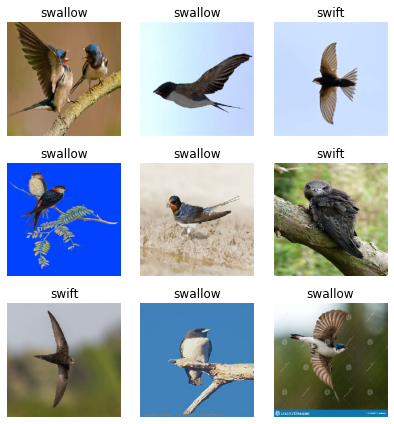

In [ ]:
fig = plt.figure(figsize=(6, 6))
images = train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[0][i])
    plt.title(class_names[np.int8(images[1][i])])
    plt.axis('off')
    plt.tight_layout()

__Lưu ý:__ 
Ở đây chúng ta có thể thấy 1 vài hình ảnh đang bị bóp méo đi, lý do là vì khi ảnh to hơn về chiều dài/rộng so với target_size, thì phần dài/rộng này sẽ được co lại để ảnh có thể vừa với kích cỡ cuối.

In [ ]:
base_model.fit(train_ds, epochs=10, validation_data=valid_ds)

Epoch 1/10
7/7 [==============================] - 1s 119ms/step - loss: 1.9382 - accuracy: 0.6465 - val_loss: 2.5856 - val_accuracy: 0.5116
Epoch 2/10
7/7 [==============================] - 1s 122ms/step - loss: 1.2323 - accuracy: 0.6869 - val_loss: 3.5195 - val_accuracy: 0.5349
Epoch 3/10
7/7 [==============================] - 1s 115ms/step - loss: 2.3134 - accuracy: 0.5859 - val_loss: 1.7531 - val_accuracy: 0.5349
Epoch 4/10
7/7 [==============================] - 1s 113ms/step - loss: 0.6658 - accuracy: 0.7778 - val_loss: 1.4617 - val_accuracy: 0.4884
Epoch 5/10
7/7 [==============================] - 1s 108ms/step - loss: 1.9522 - accuracy: 0.6162 - val_loss: 3.3334 - val_accuracy: 0.4884
Epoch 6/10
7/7 [==============================] - 1s 113ms/step - loss: 1.2418 - accuracy: 0.6869 - val_loss: 2.1129 - val_accuracy: 0.4884
Epoch 7/10
7/7 [==============================] - 1s 109ms/step - loss: 1.8245 - accuracy: 0.5556 - val_loss: 2.5015 - val_accuracy: 0.4884
Epoch 8/10
7/7 [====

### Các phương pháp biến đổi dữ liệu (data augmentation)
> Trong biến đổi dữ liệu với hình ảnh, có rất nhiều các phương pháp biến đổi khác nhau (ngoài resize, zero-center):
- Rotation/Flip
- Brightness/Constrast
- fill
- zoom
- zca whitening
- ...

#### Rotation (xoay)

In [ ]:
data_generator = image.ImageDataGenerator(
    rotation_range=120
    , rescale=1./255
    , fill_mode='nearest' # phản chiếu lại ảnh nếu ảnh bị trống khi xoay ảnh
)
sample = data_generator.flow_from_directory(
    directory=f'{path}/sw/train'
    , batch_size=9
    , shuffle=True
    , target_size=(224, 224)
)

Found 99 images belonging to 2 classes.


For each sample: 

    - first [] is for 1 batch (iteration), each batch is a tuple (element number = number of iterations)
    - 2nd [] refer to element of the tuple (0 or 1 --> 0 is X, 1 is y)
    - 3rd [] refers to element of the list (of items in a batch for either X or y)

In [ ]:
print('số lượng batch: ',len(sample), '\nX và y: ', len(sample[0]), '\nSố lượng ảnh trong 1 batch: ', len(sample[0][0]))

số lượng batch:  11 
X và y:  2 
Số lượng ảnh trong 1 batch:  9


In [ ]:
repeat_images = [sample[1][0][0] for i in range(10)]
label = list(sample.class_indices.keys())[np.int8(sample[0][1][0][1])]

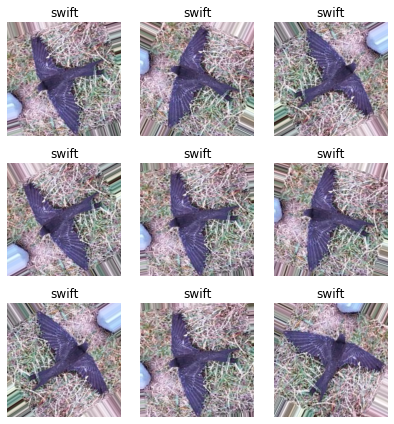

In [ ]:
figure = plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(repeat_images[i])
    plt.title(label)
    plt.axis('off')
    plt.tight_layout()

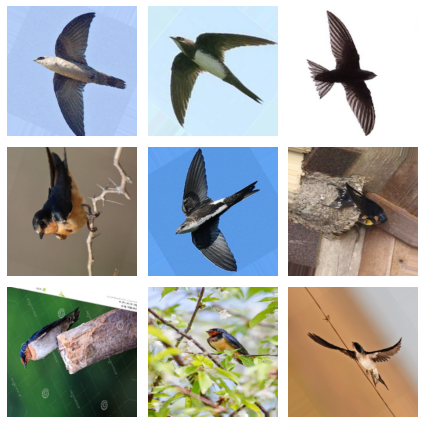

In [ ]:
## Xem các ảnh khác:
images = sample.next()
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[0][i])
    plt.axis('off')
    plt.tight_layout()

__Lưu ý:__
Chúng ta có thể thấy khi xoay ảnh, phần trống ở các góc đã được thay thế bằng dữ liệu gần ngay cạnh hình ảnh. Hiện cơ chế refection (phản chiếu) chưa được hỗ trợ với việc xoay dữ liệu bị trống này.

__Tạo Functions hỗ trợ:__
Chúng tao sẽ tạo ra 3 functions để hỗ trợ việc thử các phương pháp biến đổi dữ liệu này:

In [ ]:
# Tạo hàm sinh ra data generator từ các đk biến đổi dữ liệu aug_tfms và load dữ liệu từ folder:
def get_data_generator(aug_tfms: dict, bs:int=32, size:int=224, seed=42):
    return image.ImageDataGenerator(**aug_tfms).flow_from_directory(
        directory=f'{path}/sw/train'
        , batch_size=bs
        , target_size=(size, size)
        , shuffle=True
        , seed=seed
    )

# Tạo hàm sinh ra dữ liệu lặp lại sample để vẻ từ data generator:
def get_repeat_images(aug_tfms:dict, seed:int) -> tuple:
    # batch_size:
    bs = 9
    sample = get_data_generator(aug_tfms, bs=bs, seed=seed)
    class_names = list(sample.class_indices.keys())
    repeat_images = [sample[0][0][0] for i in range(bs)]
    label = class_names[np.int8(sample[0][1][0][1])]
    label = [label for i in range(bs)]
    return (repeat_images, label)

# # Tạo hàm sinh dữ liệu ngẫu nhiên sample từ data generator:
def get_sample_images(aug_tfms, seed):
    # batch_size:
    bs = 9
    sample = get_data_generator(aug_tfms, bs=bs, seed=seed)
    sample_images = sample.next()
    class_names = list(sample.class_indices.keys())
    images = sample_images[0]
    label = [class_names[np.int8(sample_images[1][i][1])] for i in range(bs)]
    return (images, label)
    

# Tạo hàm vẽ dữ liệu sample:
def plot_images(images):
    plt.figure(figsize=(6, 6))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[0][i])
        plt.title(images[1][i])
        plt.axis('off')
        plt.tight_layout()

#### Flip (lật)
> flip thì có 2 loại: horizontal - ngang, vertical - dọc.
> về bản chất, flip ko có gì khác mấy so vs rotate với góc 180

In [ ]:
aug_tfms = dict(rescale=1./255
    , fill_mode='nearest'
    , horizontal_flip=True
#     , vertical_flip=True
)

In [ ]:
repeat_sample = get_repeat_images(aug_tfms, seed=1)
sample = get_sample_images(aug_tfms, seed=1)

Found 99 images belonging to 2 classes.
Found 99 images belonging to 2 classes.


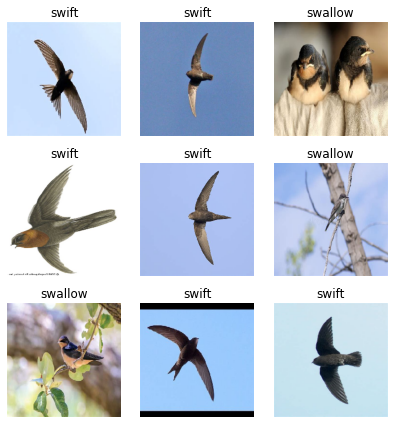

In [ ]:
plot_images(sample)

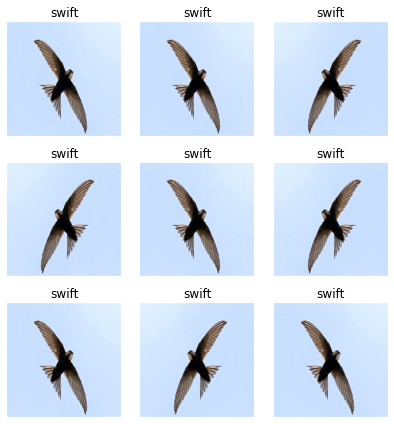

In [ ]:
plot_images(repeat_sample)

In [ ]:
# repeat_images = [sample[1][0][0] for i in range(9)]
# label = class_names[np.int8(sample[1][1][0][1])]
# fig = plt.figure(figsize=(6, 6))
# for i in range(9):
#     plt.subplot(3, 3, i+1)
#     plt.imshow(repeat_images[i])
#     plt.title(label)
#     plt.axis('off')
#     plt.tight_layout()

#### Brightness

In [ ]:
# Sử dụng brightness_range:
aug_tfms = dict(rescale=1./255
    , fill_mode='nearest'
    , brightness_range=(.2, .95)
)
repeat_sample = get_repeat_images(aug_tfms, seed=1)
sample = get_sample_images(aug_tfms, seed=1)

Found 99 images belonging to 2 classes.
Found 99 images belonging to 2 classes.


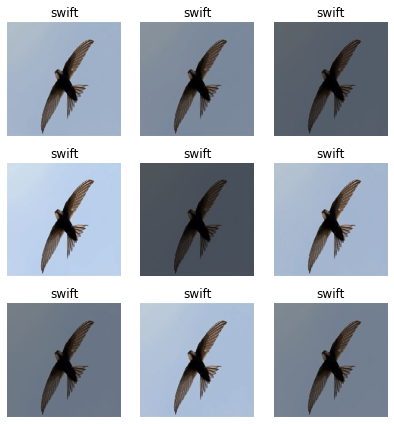

In [ ]:
plot_images(repeat_sample)

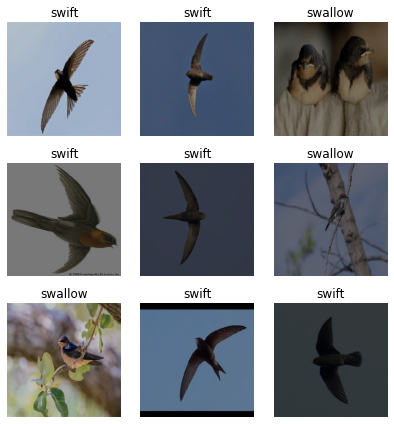

In [ ]:
plot_images(sample)

#### zca whitening:
> zca whitening là phương pháp làm nhạt ảnh bằng cách tạo thu nhỏ bớt các giá trị pixel của ảnh
- Có 2 biến liên quan đến zca whitening: zca_whitening=True để lựa chọn phương pháp và zca_epsilon=1e-6 (mặc định) để sửa giá trị 

In [ ]:
aug_tfms = dict(
    rescale=1./255
    , zca_whitening=True
    , zca_epsilon=5e-6
)
sample = get_sample_images(aug_tfms, seed=1)
repeat_sample = get_repeat_images(aug_tfms, seed=1)

Found 99 images belonging to 2 classes.
Found 99 images belonging to 2 classes.


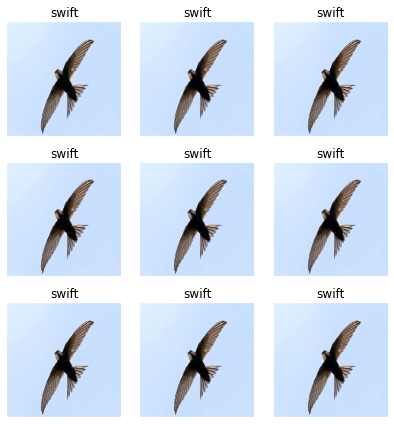

In [ ]:
plot_images(repeat_sample)

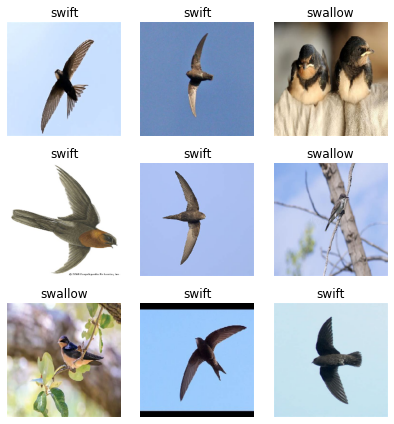

In [ ]:
plot_images(sample)

#### shifting
> Shifting là phương pháp dịch chuyển ảnh theo chiều ngang (theo độ sâu của ảnh - width), và theo chiều dọc (theo chiều cao của ảnh -height)

In [ ]:
?image.ImageDataGenerator

Init signature:
image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None,
)
Docstring:     
Generate batches of tensor image data with real-time data augmentation.

 The data will be looped over (in batches).

Arguments:
    featurewise_center: Boolean.
        Set input mean to 0 over the dataset, feature-wise.
    samplewise_center: Boolean. Set each sample mean to 0.
    featurewise_std_normalization: Boolean.
        Divide inputs by std of the dataset, fe

In [ ]:
aug_tfms = dict(
    rescale=1./255
    , width_shift_range=.3
    , height_shift_range=-.3
)
sample = get_sample_images(aug_tfms, seed=1)
repeat_sample = get_repeat_images(aug_tfms, seed=1)

Found 99 images belonging to 2 classes.
Found 99 images belonging to 2 classes.


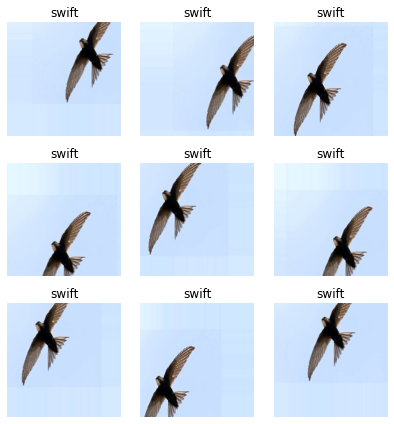

In [ ]:
plot_images(repeat_sample)

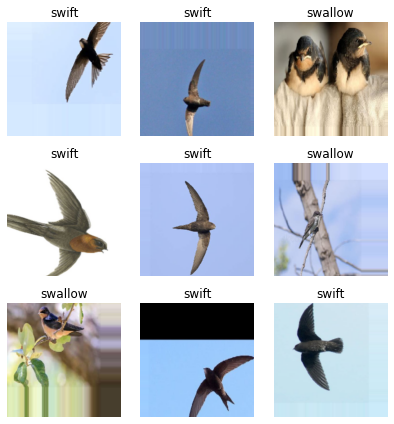

In [ ]:
plot_images(sample)

__Lưu ý:__
Phần ảnh thiếu được lấp bằng những pixcel gần nhất (fill_mode='nearest').

#### Zoom
zoom như chúng ta biết là tập trung vào 1 điểm trong ảnh và phóng đại ảnh ra. Điểm tập trung sẽ là tâm ảnh, còn zoom_range là tỷ lệ zoom giữ giá trị lớn nhất và nhỏ nhất. Nên ảnh có thể tăng/giảm size theo cấp số nhân.

In [ ]:
aug_tfms = dict(rescale=1./255, zoom_range=[1-.5, 1+.5])
sample = get_sample_images(aug_tfms, seed=1)
repeat_sample = get_repeat_images(aug_tfms, seed=1)

Found 99 images belonging to 2 classes.
Found 99 images belonging to 2 classes.


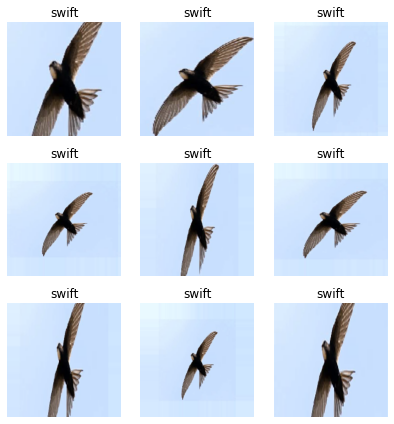

In [ ]:
plot_images(repeat_sample)

#### Shear
Là phương pháp biến đổi mặt phẳng của hình ảnh theo trục x hoặc y. Rất nhiều ảnh được chụp lại trong chiều không gian không trực diện với máy chụp, do vậy hình ảnh nhận thấy không thực sự giống thực, shear-intensity hỗ trợ việc xoay chiều ảnh để anh có thể trở về vị trí trực diện hơn với góc nhìn thực tế.
Hoặc có thể là ngược lại, nhằm tạo độ khó cho ảnh, giúp model học tốt hơn.

In [ ]:
?image.ImageDataGenerator

Init signature:
image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None,
)
Docstring:     
Generate batches of tensor image data with real-time data augmentation.

 The data will be looped over (in batches).

Arguments:
    featurewise_center: Boolean.
        Set input mean to 0 over the dataset, feature-wise.
    samplewise_center: Boolean. Set each sample mean to 0.
    featurewise_std_normalization: Boolean.
        Divide inputs by std of the dataset, fe

In [ ]:
aug_tfms = dict(rescale=1./255, shear_range=30)
sample = get_sample_images(aug_tfms, seed=1)
repeat_sample = get_repeat_images(aug_tfms, seed=1)

Found 99 images belonging to 2 classes.
Found 99 images belonging to 2 classes.


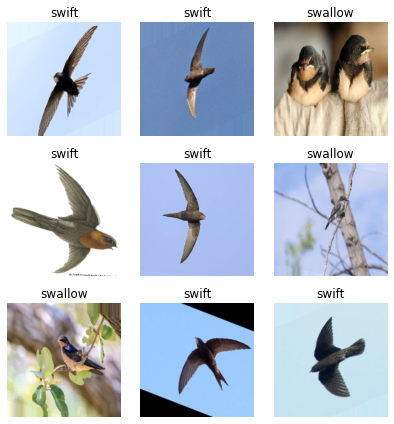

In [ ]:
plot_images(sample)

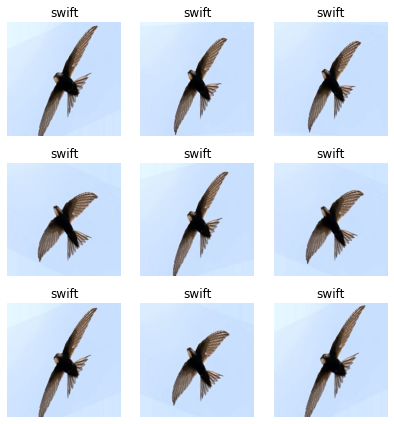

In [ ]:
plot_images(repeat_sample)

#### Preprocessing_function
Ngoài ra chúng ta có thể bổ sung thêm các phương pháp biến đổi dữ liệu khác (nếu có thông qua processing_fuction). Giống như hàm `preprocess_ds_adj` chúng ta đã làm ở trên.

### Biến đổi dữ liệu vs layers.experimental.preprocessing

In [ ]:
from keras.layers.experimental import preprocessing
from keras.layers.experimental.preprocessing import *

In [ ]:
dir(preprocessing)

['CategoryCrossing',
 'CategoryEncoding',
 'CenterCrop',
 'Discretization',
 'Hashing',
 'IntegerLookup',
 'Normalization',
 'PreprocessingLayer',
 'RandomContrast',
 'RandomCrop',
 'RandomFlip',
 'RandomHeight',
 'RandomRotation',
 'RandomTranslation',
 'RandomWidth',
 'RandomZoom',
 'Rescaling',
 'Resizing',
 'StringLookup',
 'TextVectorization',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys']

Việc coi biến đổi dữ liệu thành một dạng layer của NN là khá mới mẻ, rất khác so với tư duy ý tưởng của pytorch hay fastai. Tuy nhiên, ở đây Francois Chollet cũng đề cập việc thay vì fit dữ liệu thì chúng ta sẽ adapt dữ liệu.

Có 2 hướng thực hiện việc này:
1. Coi layer này (preprocessing layer) là 1 phần của model
2. Tách biệt giữa preprocessing với model.

Với phương pháp 1, chúng ta được lợi thế là tận dụng lại tài nguyên GPU nên tốc độ nhanh hơn, ngoài ra, trong quá trình inference (predict các ảnh mới) thì các ảnh sẽ được đẩy luôn vào layer preprocessing mà không phải lo lắng về việc biến đổi dữ liệu ntn trước khi chạy model. Phương pháp 1 này khá tương đồng với cách thức thực hiện dataloader củu fastai và pytorch. Tất nhiên cả 2 phương pháp đều thực hiện real-time tại thời điểm train/fit model.

In [ ]:
?preprocessing.PreprocessingLayer

Init signature: preprocessing.PreprocessingLayer(*args, **kwargs)
Docstring:      Base class for PreprocessingLayers.
File:           ~/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_preprocessing_layer.py
Type:           ABCMeta
Subclasses:     CombinerPreprocessingLayer, Resizing, CenterCrop, RandomCrop, Rescaling, RandomFlip, RandomTranslation, RandomRotation, RandomZoom, RandomContrast, ...


In [ ]:
# Tạo preprocessing layer:
input = keras.Input(shape=(460, 460, 3))
preprocessing_layer = keras.Sequential([
    preprocessing.Resizing(224, 224, interpolation='nearest') # cho về size của model
    , preprocessing.Rescaling(scale=1./255)
    , preprocessing.Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229**2, 0.224**2, 0.225**2]) # thông số của imagenet
])

In [ ]:
# Tạo một ImageDataGenerator:
data_gen = keras.preprocessing.image.ImageDataGenerator() ## tạo tập generator trống (ko có phương pháp biến đổi dữ liệu)

# Tạo train & valid generator:
bs = 16
train_ds = data_gen.flow_from_directory(
    directory=f'{path}/sw/train'
    , target_size=(460, 460) # Mở size cho các ảnh để dễ trong việc biến đổi dữ liệu ở các bước sau
    , class_mode='categorical'
    , batch_size=bs
    , shuffle=True
)
valid_ds = data_gen.flow_from_directory(
    directory=f'{path}/sw/test'
    , target_size=(460, 460)
    , class_mode='categorical'
    , batch_size=bs
    , shuffle=True
)

Found 99 images belonging to 2 classes.
Found 43 images belonging to 2 classes.


In [ ]:
# Chúng ta sẽ sử dụng image_dataset_from_directory:
bs = 16
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory=f'{path}/sw/train'
    , labels='inferred'
    , label_mode='binary'
    , image_size=(224, 224)
    , batch_size=bs
    , shuffle=True
)
valid_ds = keras.preprocessing.image_dataset_from_directory(
    directory=f'{path}/sw/test'
    , labels='inferred'
    , label_mode='binary'
    , image_size=(224, 224)
    , batch_size=bs
    , shuffle=True
)

# Prefetch dữ liệu trên CPU để sẵn sàng cho cách lần train:
train_ds = train_ds.prefetch(buffer_size=16)
valid_ds = valid_ds.prefetch(buffer_size=16)

Found 99 files belonging to 2 classes.
Found 43 files belonging to 2 classes.


In [ ]:
train_ds, valid_ds

(<BatchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float32)>)

AttributeError: 'DirectoryIterator' object has no attribute 'prefetch'

In [ ]:
resnet_model = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=[224, 224, 3])

In [ ]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Tạo model resnet50:
def create_resnet(input_size:int, class_num:int=2):
    activation = 'sigmoid'
    if class_num > 2: activation = 'softmax'
    input = keras.Input(shape=(460, 460, 3))
    x = keras.Sequential([
        preprocessing.Resizing(224, 224, interpolation='nearest') # cho về size của model
        , preprocessing.Rescaling(scale=1./255)
        , preprocessing.Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229**2, 0.224**2, 0.225**2]) # thông số của imagenet
    ])(input)
    resnet_model = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
#     for layer in resnet_model.layers:
#         layer.trainable=False
#         x = layer(x)
#     if class_num > 2: activation = 'softmax'
#     # Add flatten and prediction layers:
#     flatten = keras.layers.Flatten(name='flatten')(x)
#     prediction = keras.layers.Dense(class_num, activation=activation, name='prediction')(flatten)
#     model = keras.Model(inputs=input, outputs=prediction)

    # Freeze resnet_model layers:
    for layer in resnet_model.layers:
        layer.trainable = False
    #Concatenate preprocessing layer and resnet_layers:
    resnet_model = resnet_model(x)
    # Add flatten and prediction layers:
    flatten = keras.layers.Flatten(name='flatten')(resnet_model)
    prediction = keras.layers.Dense(class_num, activation=activation, name='prediction')(flatten)
    model = keras.Model(inputs=input, outputs=prediction)
    return model

In [ ]:
model = create_resnet(460, 2)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 460, 460, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       7         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
prediction (Dense)           (None, 2)                 200706    
Total params: 23,788,425
Trainable params: 200,706
Non-trainable params: 23,587,719
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=5, validation_data=valid_ds)

Epoch 1/5


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [32,2] and labels shape [64]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-21-969ee7d129b6>:1) ]] [Op:__inference_train_function_27047]

Function call stack:
train_function


**Lưu ý:**

Phương pháp ở trên hiện chưa thể thực hiện được. Có thể thay vì trồng lớp preproccessing layer dưới lớp pretrained_layer, chúng ta phải tạo ra model từng layer 1, tuy nhiên sẽ không thể tận dụng được tầng pretrained của model mà chỉ xây dựng lại kiến trúc của model (resnet) mà thôi.

In [ ]:
# Preprocessing layer:
# Tạo preprocessing layer:
input = keras.Input(shape=(460, 460, 3))
preprocessing_layer = keras.Sequential([
    preprocessing.Resizing(224, 224, interpolation='nearest') # cho về size của model
    , preprocessing.Rescaling(scale=1./255)
    , preprocessing.Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229**2, 0.224**2, 0.225**2]) # thông số của imagenet
])(input)

# Thử cách khác (vẫn cố gắng tận dụng pretrained model):
resnet_model = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
resnet_model = resnet_model(preprocessing_layer)
flatten = keras.layers.Flatten(name='flatten')(resnet_model)
prediction = keras.layers.Dense(2, activation='softmax', name='prediction')(flatten)
model = keras.Model(inputs=input, outputs=prediction)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 460, 460, 3)]     0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 224, 224, 3)       7         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
prediction (Dense)           (None, 2)                 200706    
Total params: 23,788,425
Trainable params: 23,735,298
Non-trainable params: 53,127
_________________________________________________________________


#### Xây dựng model từ đầu với preprocessing layer

In [ ]:
from keras.layers.experimental import preprocessing
from keras.layers.experimental.preprocessing import *

In [ ]:
dir(preprocessing)

['CategoryCrossing',
 'CategoryEncoding',
 'CenterCrop',
 'Discretization',
 'Hashing',
 'IntegerLookup',
 'Normalization',
 'PreprocessingLayer',
 'RandomContrast',
 'RandomCrop',
 'RandomFlip',
 'RandomHeight',
 'RandomRotation',
 'RandomTranslation',
 'RandomWidth',
 'RandomZoom',
 'Rescaling',
 'Resizing',
 'StringLookup',
 'TextVectorization',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [ ]:
# Tạo ra preprocessing layer:
sample_preprocess = keras.Sequential([
    preprocessing.Resizing(224, 224, interpolation='nearest') # cho về size của model
    , preprocessing.RandomFlip('vertical')
    , preprocessing.Rescaling(scale=1./255)
    , preprocessing.Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229**2, 0.224**2, 0.225**2]) # thông số của imagenet
    
])

In [ ]:
class_names = list(train_ds.class_indices.keys())
class_names

['swallow', 'swift']

In [ ]:
# Tạo một batch:
images = train_ds.next()
images[0].shape, images[1].shape

((16, 460, 460, 3), (16, 2))

In [ ]:
# chia thành image và labels:
images, labels = images[0], images[1]

In [ ]:
labels[0].shape

(2,)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


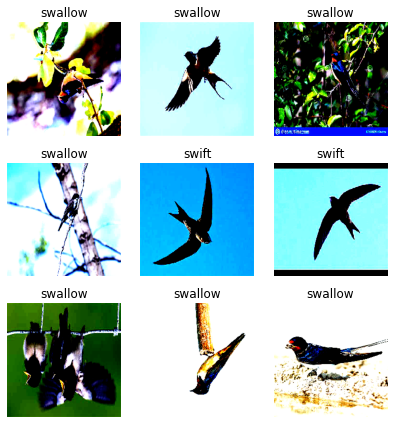

In [ ]:
# Kiểm tra anh với sample preprocessing:
plt.figure(figsize=(6, 6))
images = sample_preprocess(images)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_names[np.int8(labels[i][1])])
    plt.axis('off')
    plt.tight_layout()

In [ ]:
preprocess_layer = keras.Sequential([
    preprocessing.Resizing(224, 224, interpolation='nearest') # cho về size của model
    , preprocessing.RandomFlip('vertical')
    , preprocessing.Rescaling(scale=1./255)
    , preprocessing.Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229**2, 0.224**2, 0.225**2]) # thông số của imagenet
    
])

#### Xây dựng mode từ đầu
Xây dựng mô hình từ đầu: nguồn - [keras image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/)

In [ ]:
# Xây dựng model:

def create_model(input_shape:tuple, num_class:int):
    activation='sigmoid'
    units = 1
    if num_class > 2: 
        activation='softmax'
        units = num_class
        
    inputs = keras.layers.Input(shape=input_shape)
    x = preprocess_layer(inputs)
    
    # entry block:
    x = keras.layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(64, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    previous_block_activation = x # set a side residual block
    
    for size  in [128, 256, 512, 728]:
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.SeparableConv2D(size, 3, padding='same')(x)
        x = keras.layers.BatchNormalization()(x)
    
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.SeparableConv2D(size, 3, padding='same')(x)
        x = keras.layers.BatchNormalization()(x)
        
        x = keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)
        
        # project residual:
        residual = keras.layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        x = keras.layers.add([x, residual]) # add back residual block
        previous_block_activation = x # set aside next residual block
        
    x = keras.layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [ ]:
model = create_model((224, 224, 3), 2)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 224, 224, 3)  7           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         sequential_1[0][0]               
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
______________________________________________________________________________________________

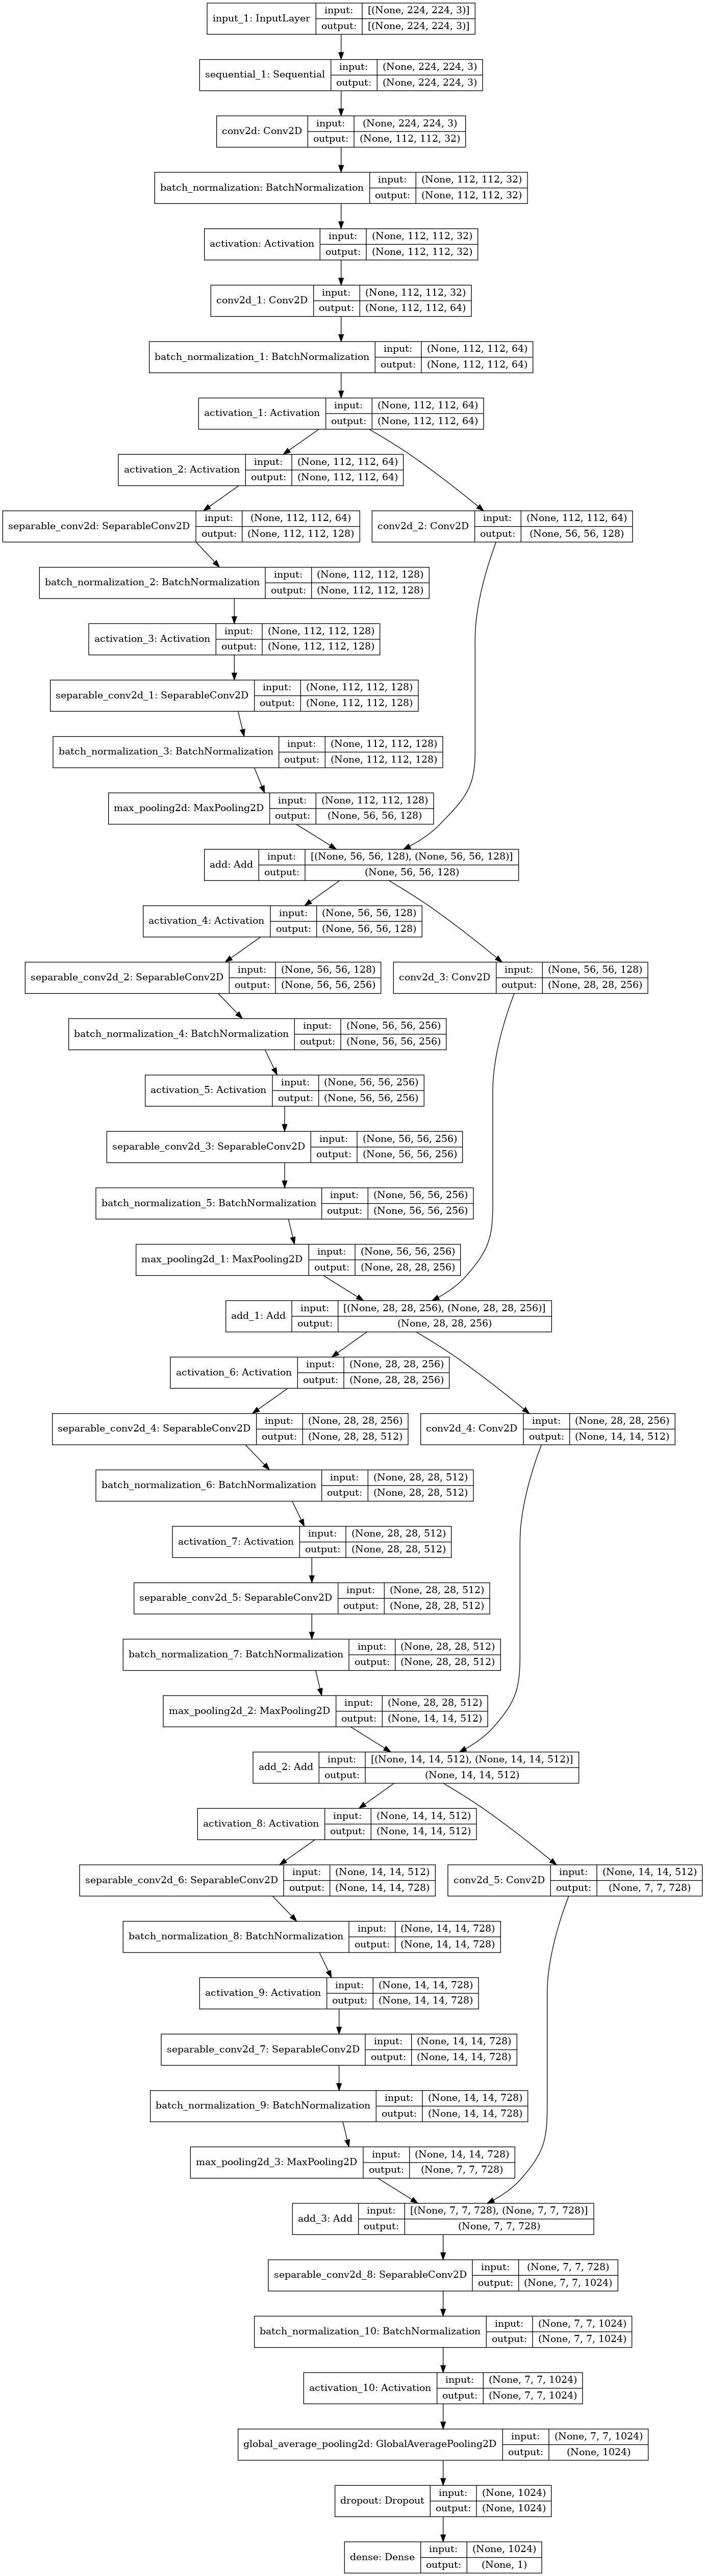

In [ ]:
# Vẽ model:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
# Train model:
callbacks = [keras.callbacks.ModelCheckpoint(f'save_at_{epochs}.h5')]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3)
    , loss = 'binary_crossentropy'
    , metrics=['accuracy']
)

In [ ]:
epochs = 5
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds)

Epoch 1/5
7/7 [==============================] - 10s 568ms/step - loss: 0.8520 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
7/7 [==============================] - 2s 249ms/step - loss: 0.7528 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
7/7 [==============================] - 2s 251ms/step - loss: 0.7470 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
7/7 [==============================] - 2s 258ms/step - loss: 0.7518 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
7/7 [==============================] - 2s 247ms/step - loss: 0.7347 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


#### Kết hợp giữa preprocessing vs pretrained model
Như chúng ta đã cố gắng lắp ghép preprocessing layer và pretrained model ở trên thành một DNN, tuy nhiên công việc này đã không thực sự thành công.
Để kết hợp được giữa preprocessing layer và pretrained model, chúng ta sẽ thử lại bằng cách tách biệt 2 phần này thành 2 layers khác nhau để xử lý.

__Dataset:__
Chúng ta sẽ chỉ sử dụng tf dataset (`image_dataset_from_directory`) cho tình huống này. Về bản chất, trong `ImageDataGenerator` đã tồn tại các phương pháp biến đổi dữ liệu. 

In [ ]:
# Tạo tập tf dataset từ image_dataset_from_directory:
bs = 16
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory=f'{path}/sw/train'
    , labels='inferred'
    , label_mode='binary'
    , batch_size=bs
    , image_size=(460, 460)
    , shuffle=True
)
valid_ds = keras.preprocessing.image_dataset_from_directory(
    directory=f'{path}/sw/train'
    , labels='inferred'
    , label_mode='binary'
    , batch_size=bs
    , image_size=(460, 460)
    , shuffle=True
)

Found 99 files belonging to 2 classes.
Found 99 files belonging to 2 classes.


In [ ]:
train_ds

<BatchDataset shapes: ((None, 460, 460, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [ ]:
# Tạo preprocessing layer:
preprocessing_layer = keras.Sequential([
    preprocessing.RandomCrop(224, 224) # crop về kích cỡ của resnet50
    , preprocessing.RandomFlip(mode='vertical')
#     , preprocessing.Rescaling(1./255)
#     , preprocessing.Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229**2, 0.224**2, 0.225**2])
])


In [ ]:
?keras.applications.resnet50.preprocess_input

Signature: keras.applications.resnet50.preprocess_input(x, data_format=None)
Docstring:
Preprocesses a tensor or Numpy array encoding a batch of images.

Usage example with `applications.MobileNet`:

```python
i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = tf.keras.applications.mobilenet.preprocess_input(x)
core = tf.keras.applications.MobileNet()
x = core(x)
model = tf.keras.Model(inputs=[i], outputs=[x])

image = tf.image.decode_png(tf.io.read_file('file.png'))
result = model(image)
```

Arguments:
  x: A floating point `numpy.array` or a `tf.Tensor`, 3D or 4D with 3 color
    channels, with values in the range [0, 255].
    The preprocessed data are written over the input data
    if the data types are compatible. To avoid this
    behaviour, `numpy.copy(x)` can be used.
  data_format: Optional data format of the image tensor/array. Defaults to
    None, in which case the global setting
    `tf.keras.backend.image_data_format()` is used (

__Lưu ý:__
Trong resnet50 đã có sẵn phương pháp: preprocess_input với mục đích biến đổi dữ liệu từ dàng RGB sang BGR, sau đó vs từng channel hình ảnh, pixels được biến đổi để thành zero-centered mà không cần thực hiện scalling, do đó 2 bước trong preprocessing sẽ được thay bằng bước preprocess_input của resnet50.

In [ ]:
# Tạo hàm biến đổi dữ liệu:
def preprocess_image(x, y):
    # Biến đổi theo preprocessing layer trước:
    x = preprocessing_layer(x, training=True)
    # Sau đó biến đổi theo preprocess_input của resnet50:
    x = keras.applications.resnet50.preprocess_input(x)
    return (x, y)

In [ ]:
# Biến đổi vớitf dataset:
train_ds = train_ds.map(preprocess_image)
valid_ds = valid_ds.map(preprocess_image)

In [ ]:
# Tạo pretrained model:
resnet = keras.applications.resnet50.ResNet50(
    include_top=False # Loại bỏ 2 layers cuối vì không phù hợp với bài toán của chúng ta
    , weights='imagenet'
    , input_shape=(224, 224, 3)
)

# Đóng băng các layer của resnet:
for layer in resnet.layers:
    layer.trainable=False

__Lưu ý:__
Như một thói quen, khi sử dụng pretrained model, chúng ta luôn luôn nhớ sẽ đóng băng (freeze) các layers của pretrained model trước để train với dữ liệu mới và bài toán mới.
Sau khi đã đạt được một kết quả rất tốt rồi, chúng ta có thể tiến hành giã đông (unfreeze) cho tất cả các layers của pretrained model. Và tiếp tục train tiếp để pretrained model được thích ứng với bài toán mới tốt nhất.

In [ ]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Tạo thêm 2 layers cuối:
flatten = keras.layers.Flatten(name='flatten')(resnet.output)
prediction = keras.layers.Dense(1, activation='sigmoid', name='prediction')(flatten)
model = keras.Model(inputs=resnet.input, outputs=prediction)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
epochs=10
model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Epoch 1/10
7/7 [==============================] - 5s 399ms/step - loss: 5.5525 - accuracy: 0.5842 - val_loss: 17.1946 - val_accuracy: 0.4747
Epoch 2/10
7/7 [==============================] - 2s 277ms/step - loss: 11.8556 - accuracy: 0.5765 - val_loss: 5.8678 - val_accuracy: 0.7475
Epoch 3/10
7/7 [==============================] - 2s 273ms/step - loss: 2.9666 - accuracy: 0.8083 - val_loss: 1.4440 - val_accuracy: 0.9091
Epoch 4/10
7/7 [==============================] - 2s 275ms/step - loss: 2.0574 - accuracy: 0.8574 - val_loss: 1.2805 - val_accuracy: 0.8687
Epoch 5/10
7/7 [==============================] - 2s 308ms/step - loss: 1.3166 - accuracy: 0.9148 - val_loss: 1.2940 - val_accuracy: 0.9192
Epoch 6/10
7/7 [==============================] - 2s 277ms/step - loss: 2.8652 - accuracy: 0.8428 - val_loss: 1.0958 - val_accuracy: 0.9293
Epoch 7/10
7/7 [==============================] - 2s 277ms/step - loss: 1.3988 - accuracy: 0.8695 - val_loss: 2.1237 - val_accuracy: 0.8788
Epoch 8/10
7/7 [==